<a href="https://colab.research.google.com/github/omkar806/Stable_Diffusion/blob/main/DAAM_SHAP_IMPLEMENTATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
print("version:", sys.version)

version: 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]


In [ ]:
!pip install diffusers==0.10.2 transformers scipy ftfy accelerate

In [ ]:
from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")

The cache for model files in Diffusers v0.14.0 has moved to a new location. Moving your existing cached models. This is a one-time operation, you can interrupt it or run it later by calling `diffusers.utils.hub_utils.move_cache()`.


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [ ]:
pipe.to("cuda")

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.16.1",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
#installing the daam library
!pip install daam

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 87.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.8/288.8 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from daam import trace, set_seed
from matplotlib import pyplot as plt
import torch
prompt = "dog running on a street"
gen = set_seed(0)
# image = pipe(prompt).images[0]

# you can save the image with


  0%|          | 0/30 [00:00<?, ?it/s]

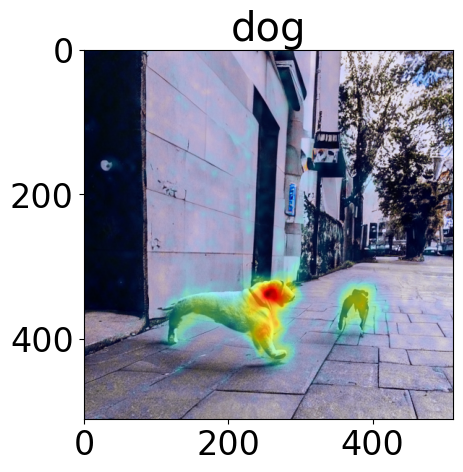

In [ ]:
with torch.cuda.amp.autocast(dtype=torch.float16), torch.no_grad():
    with trace(pipe) as tc:
        out = pipe(prompt, num_inference_steps=30, generator=gen)
        heat_map = tc.compute_global_heat_map()
        heat_map = heat_map.compute_word_heat_map('dog')
        heat_map.plot_overlay(out.images[0])
        plt.show()

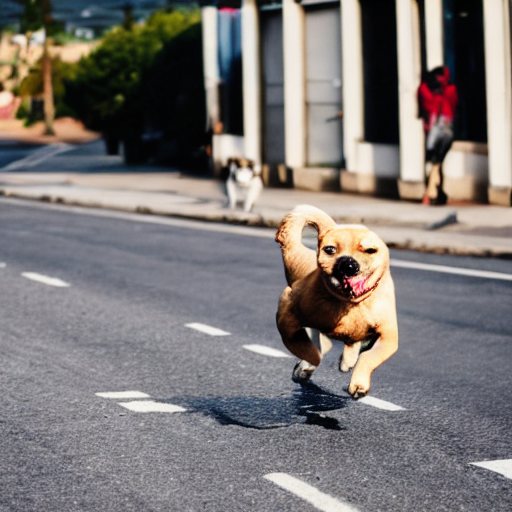

In [ ]:
image.save(f"dog_running_on_street.png")
image

In [ ]:
!pip install shap
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.1/547.1 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 17.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=2f951477611002fd01cebaddf11d755992a565e4174688f8dc3e775b0d4fe488
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import shap
import lime
from lime import lime_image

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
# Load the saved image for explanation
image_path = "dog_running_on_street.png"
input_image = Image.open(image_path)

# Define the desired image size expected by the model
image_size = (224, 224)

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Preprocess the input image
preprocessed_image = transform(input_image).unsqueeze(0)

# Apply SHAP for explaining the model's prediction
explainer = shap.Explainer(pipe)
shap_values = explainer(preprocessed_image, max_evals=301057)  # Increase max_evals

# Apply LIME for explaining the model's prediction
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(input_image, pipe.predict)